In [1]:
pip install xgboost scikit-learn numpy

In [2]:
!pip install neattext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nfx
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
import joblib

In [18]:
df = pd.read_csv("emotion_dataset.csv")
df.head()

,SL. No,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [31]:
df['Emotion'] = df['Emotion'].astype(str).str.strip().str.lower()

In [32]:
df = df[df['Emotion'].notna() & (df['Emotion'] != '') & (df['Emotion'] != 'empty')]

In [33]:
print(df['Emotion'].unique())

['hate' 'neutral' 'anger' 'love' 'worry' 'relief' 'happiness' 'fun'
 'enthusiasm' 'sadness' 'surprise' 'boredom']


In [34]:
label_counts = df['Emotion'].value_counts()
non_empty_labels = label_counts[label_counts > 0].index
df = df[df['Emotion'].isin(non_empty_labels)]

In [35]:
print(df.columns)

Index(['SL. No', 'text', 'Emotion', 'clean_text'], dtype='object')


In [38]:
df['clean_text'] = df['text'].astype(str)
df['clean_text'] = df['clean_text'].apply(nfx.remove_stopwords)
df['clean_text'] = df['clean_text'].apply(nfx.remove_punctuations)

In [39]:
X = df['clean_text']
y = df['Emotion']

In [40]:
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [43]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [44]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique classes and their integer encoded form
classes = np.unique(y_train_encoded)

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_encoded)

# Convert to dictionary for XGBoost
class_weights = dict(zip(classes, weights))

# XGBoost doesn’t accept per-class weights directly like this,
# So instead we assign sample weights:
sample_weights = np.array([class_weights[i] for i in y_train_encoded])

# Now train XGBoost with sample_weight
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train the model
model.fit(X_train_tfidf, y_train_encoded, sample_weight=sample_weights)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:04:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [45]:
y_pred_encoded = model.predict(X_test_tfidf)
y_pred = le.inverse_transform(y_pred_encoded)

y_pred_encoded = model.predict(X_test_tfidf)

y_pred = le.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test, y_pred)
print(f"Recognition Accuracy: {accuracy * 100:.2f}%")

Recognition Accuracy: 98.66%



Classification Report:
              precision    recall  f1-score   support

       anger       0.97      0.94      0.96      2465
     boredom       0.62      1.00      0.76        34
  enthusiasm       1.00      0.98      0.99      1822
         fun       0.98      0.90      0.94      2014
   happiness       0.99      0.97      0.98      5443
        hate       0.93      0.82      0.87      3005
        love       1.00      0.98      0.99      7938
     neutral       0.99      1.00      0.99    134927
      relief       0.94      0.86      0.90      3374
     sadness       1.00      0.97      0.98      3489
    surprise       1.00      0.97      0.99      1368
       worry       0.99      0.99      0.99       924

    accuracy                           0.99    166803
   macro avg       0.95      0.95      0.94    166803
weighted avg       0.99      0.99      0.99    166803



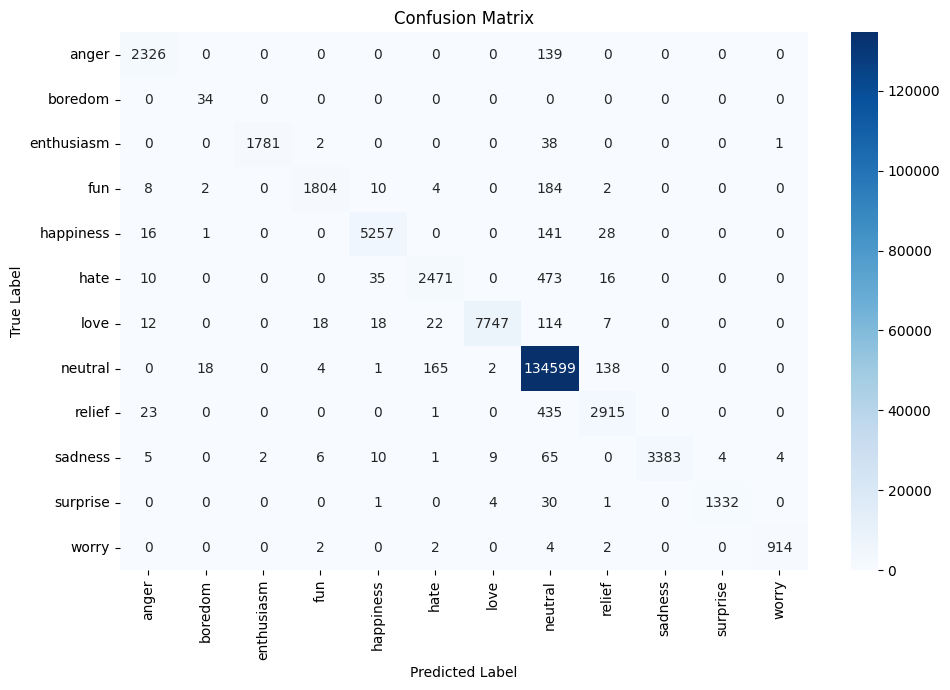

In [46]:
present_labels = np.unique(y_test)
present_labels_encoded = le.transform(present_labels)

print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    labels=present_labels,
    target_names=present_labels
))


cm = confusion_matrix(
    y_test, y_pred,
    labels=present_labels
)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_labels,
            yticklabels=present_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [47]:
joblib.dump(model, "emotion_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


In [48]:
model = joblib.load("emotion_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

def predict_emotion(text):
    clean = nfx.remove_stopwords(text)
    clean = nfx.remove_punctuations(clean)
    vec = vectorizer.transform([clean])
    pred_encoded = model.predict(vec)
    pred_label = le.inverse_transform(pred_encoded)
    return pred_label[0]

while True:
    user_input = input("Enter a sentence (or type 'exit'): ")
    if user_input.lower() == 'exit':
        break
    emotion = predict_emotion(user_input)
    print("Predicted Emotion:", emotion)

Enter a sentence (or type 'exit'): I am happy now
Predicted Emotion: happiness
Enter a sentence (or type 'exit'): She hates Rahul
Predicted Emotion: hate
Enter a sentence (or type 'exit'): I went to the store and bought some groceries.
Predicted Emotion: neutral
Enter a sentence (or type 'exit'): He was not just angry — he was absolutely furious when he saw the damage to his car.
Predicted Emotion: anger
Enter a sentence (or type 'exit'): i feel like she has taken on the role of a grandmother to me since my beloved grandma is no longer with me
Predicted Emotion: love
Enter a sentence (or type 'exit'): She felt sad after saying goodbye to her best friend who was moving away.
Predicted Emotion: sadness
Enter a sentence (or type 'exit'): exit
